# **SMAI Assignment - 2**
##### (Monsoon 2023-24)

> **Name**: *Bhav Beri*
> 
> **Roll Number**: *2021111013*

## _Problem - 2_

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from tqdm import trange
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [189]:
customer_dataset_path = "../Datasets/SMAI-Dataset-customer-dataset/data.csv"

In [203]:
class GMM:
    def __init__(self, max_iter=100):
        self.k = 3
        self.max_iter = max_iter
        self.centers = None
        self.covs = None
        self.pi = None
        self.log_likelihoods = None
        self.log_likelihood = None

    def fit(self, X, k=None, printing=True):
        if k is not None:
            self.k = k
        n, d = X.shape
        self.centers = X[np.random.choice(n, self.k, replace=False)]

        dataframe = pd.DataFrame(X)
        self.covs = np.array([dataframe.cov().to_numpy()] * self.k)
        
        self.pi = np.array([1 / self.k] * self.k)
        self.log_likelihoods = []
        self.log_likelihood = None

        while(1):
            starting=self._compute_log_likelihood(X)
            # E-step
            gamma = self._expectation(X)
            # M-step
            self._maximization(X, gamma)
            # Compute log-likelihood
            self.log_likelihood = self._compute_log_likelihood(X)
            ending=self.log_likelihood
            if(abs(ending-starting)<1.0e-3):
                break
            self.log_likelihoods.append(self.log_likelihood)
            print(self.log_likelihood)
            
            if len(self.log_likelihoods) > 1 and np.abs(self.log_likelihoods[-1] - self.log_likelihoods[-2]) < 1e-3:
                break
        
        if printing:
            print("Centers: ", self.centers)
            print("Covariances: ", self.covs)
            print("Pi: ", self.pi)
            print("Log-likelihood: ", self.log_likelihood)
    
    def _expectation(self, X):
        n, d = X.shape
        gamma = np.zeros((n, self.k))
        # for i in range(n):
        for j in range(self.k):
            gamma[:, j] = self.pi[j] * self._gaussian(X, self.centers[j], self.covs[j])
        gamma[:] /= np.sum(gamma[:], axis=1).reshape(-1, 1)
        return gamma
    
    def _maximization(self, X, gamma):
        n, d = X.shape
        gamma = gamma.transpose()
        class_responsibilities = np.sum(gamma, axis=1)

        for i in range(self.k):
            self.pi[i] = class_responsibilities[i] / n

            weighted_sum = np.zeros((d,))
            for j in range(n):
                weighted_sum += gamma[i][j] * X[j]
            self.centers[i] = weighted_sum / class_responsibilities[i]

            cov_sum = np.zeros((d, d))
            for j in range(n):
                diff = X[j] - self.centers[i]
                cov_sum += (gamma[i][j] / class_responsibilities[i]) * np.outer(diff, diff)
            self.covs[i] = cov_sum + np.eye(d) * 1.0e-6

    def _compute_log_likelihood(self, X):
        n, d = X.shape

        temp = np.empty((self.k, X.shape[0]))
        for i in range(self.k):
            temp[i] = (
                self.pi[i]
                * self._gaussian(
                    X, self.centers[i], self.covs[i]
                )
            ).T
        sum_of_probabilities = np.sum(temp, axis=0)
        return np.sum(np.log(sum_of_probabilities))

    
    def _gaussian(self, x, mean, cov):
        d = x.shape[1] 
        
        # Step 1: Calculate the Mahalanobis distances
        diff = x - mean 
        cov_inv = np.linalg.inv(cov)
        mahalanobis_dist = np.sum(diff @ cov_inv * diff, axis=1)  # Transpose diff
        
        # Step 2: Calculate the Gaussian probability densities
        exponent = -0.5 * mahalanobis_dist
        denominator = np.sqrt((2 * np.pi) ** d * np.linalg.det(cov))
        probability_density = np.exp(exponent) / denominator
        
        return probability_density

    def predict(self, X):
        n, d = X.shape
        cluster_assignments = np.zeros(n, dtype=int)
        
        likelihoods = np.zeros((n, self.k))
        for j in range(self.k):
            likelihoods[:, j] = self._gaussian(X, self.centers[j], self.covs[j])
        
        cluster_assignments = np.argmax(likelihoods, axis=1)
        return cluster_assignments

    def plot_log_likelihood(self):
        plt.plot(self.log_likelihoods)
        plt.xlabel('Iteration')
        plt.ylabel('Log-likelihood')
        plt.show()

    def aic(self, data = None):
        num_params = self.k * ((data.shape[1] * (data.shape[1] + 1)) / 2) - self.k + self.k * data.shape[1]
        return 2 * num_params - 2 * self.log_likelihood
    
    def bic(self, data = None):
        num_params = self.k * ((data.shape[1] * (data.shape[1] + 1)) / 2) - self.k + self.k * data.shape[1]
        return np.log(data.shape[0]) * num_params - 2 * self.log_likelihood
    
    def get_membership(self, data):
        num_samples = data.shape[0]
        probabilities = np.empty((self.k, num_samples))

        for i in range(self.k):
            likelihood = self._gaussian(data, self.centers[i], self.covs[i]).T
            probabilities[i] = self.pi[i] * likelihood

        membership = np.empty(num_samples)
        for i in range(num_samples):
            membership[i] = np.argmax(probabilities[:, i])

        return membership

In [191]:
# Load the Data
X = pd.read_csv(customer_dataset_path)
X = X.drop(['Index'], axis=1)
X = X.to_numpy()

# Fit the model
model = GMM()
model.fit(X, k=3)

-39336.879101335326
-39137.78387566254
-38598.634651770626
-38315.39290079247
-37486.667155914154
-30148.03213757099
-29023.712489646634
-28700.964811872436
-28482.846596786607
-28342.944935052663
-28340.706437280664
-28338.696016705173
-28338.548358051863
-28338.585770678954
-28338.60654252713
-28338.617938351017
-28338.612170810422
-28338.60682194936
-28338.600519586907
Centers:  [[     0      0     37      0 140980      1      1]
 [     0      0     35      1 135194      1      1]
 [     0      0     34      1  99170      0      0]]
Covariances:  [[[ 3.63661471e-01  3.63660471e-01 -8.00791421e-01  4.89787678e-01
   -1.59315779e+03  4.96518688e-02  1.05306248e-01]
  [ 3.63660471e-01  3.63661471e-01 -8.00791421e-01  4.89787678e-01
   -1.59315779e+03  4.96518688e-02  1.05306248e-01]
  [-8.00791421e-01 -8.00791421e-01  1.60467182e+02  6.64942001e+00
    1.73339261e+05  1.03396188e+00  4.72808152e-01]
  [ 4.89787678e-01  4.89787678e-01  6.64942001e+00  1.43061318e+00
    6.41179892e+03  

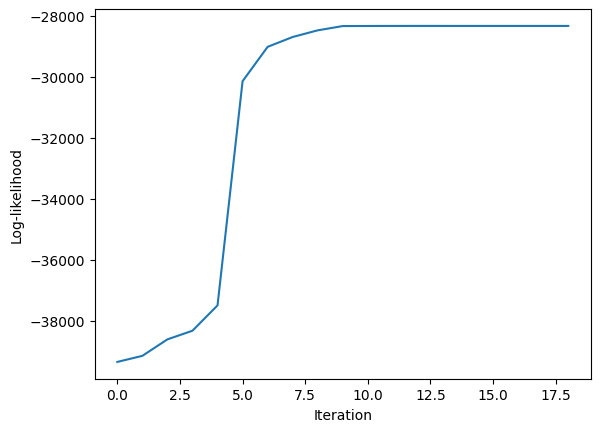

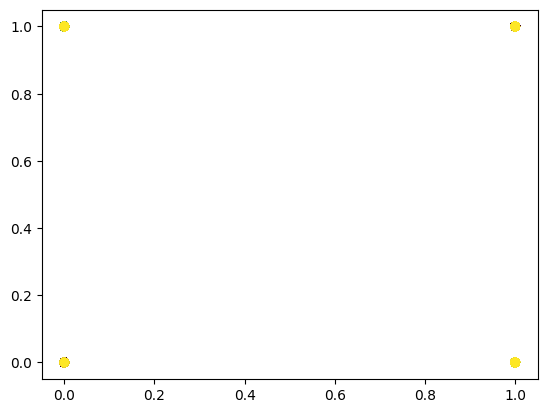

In [192]:
# Plot the log-likelihood
model.plot_log_likelihood()

# Plot the clusters
y = model.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [193]:
model = GMM()

for i in [2,3,5,7]:
    model.fit(X, k=i, printing=False)

    # Plot the clusters
    y = model.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title("K = " + str(i))
    plt.show()

> ##### Observations

As we vary the number of clusters (k) in our analysis, we notice a trend in the maximum prior probabilities associated with each cluster – they tend to decrease as k increases. The 'Means' array, which has a dimension of k by 7 (where 7 represents the number of features used in GMM), and the Covariances matrix, with dimensions of k by k by 7, reflect the structure of our data. Furthermore, the dimensions of the Prior Probabilities vector are k by 1, and their sum always equals 1, as expected.

It's worth noting that the Covariance Matrix often contains very small values in many places, indicating subtle correlations between the corresponding attributes. The computed means fall within reasonable ranges observed in the dataset, suggesting that the algorithm's results accurately represent the provided data. This, in turn, signifies the effectiveness of the GMM clustering process.

Also, with either high or low value of K, the algorithm is not able to cluster the data properly. This is because, with a high value of K, the algorithm tries to fit the data too much, and with a low value of K, the algorithm is not able to fit the data properly.

In [194]:
data = load_wine()
X = data.data

In [195]:
# To check GMM working

model = GMM()
model.fit(X, k=2)

-3225.162092322911
-3188.2543884523016
-3171.3599234205117
-3163.3485767522425
-3152.1113462565195
-3135.134282881225
-3126.037734096042
-3114.6391389132814
-3112.4452948908156
-3111.6621060742614
-3110.3365257081186
-3105.534144179658
-3090.6352500136963
-3066.373052173275
-3059.1525041382865
-3051.8858195850016
-3043.489499885115
-3042.832431494675
-3042.6132640817677
-3042.3759555200786
-3041.697210738673
-3041.1608290291433
-3041.1259910605377
-3041.1202496819287
-3041.117545119172
-3041.115977981033
Centers:  [[1.29814496e+01 3.26226838e+00 2.38284942e+00 2.05503789e+01
  9.89122888e+01 1.97512139e+00 1.33062522e+00 4.16353704e-01
  1.32864539e+00 5.95591532e+00 7.80113492e-01 2.10732068e+00
  6.14479441e+02]
 [1.30148231e+01 1.65017723e+00 2.35441329e+00 1.87127931e+01
  1.00356130e+02 2.53224789e+00 2.54701373e+00 3.21465816e-01
  1.78524693e+00 4.39273887e+00 1.08886769e+00 2.98545468e+00
  8.45021095e+02]]
Covariances:  [[[ 4.61479553e-01  1.45780639e-01  4.50415622e-02  5.299

In [198]:
aic, bic = list(), list()
max_range = 150

for k in trange(1, max_range):
    print("k = ", k)
    model = GMM()
    model.fit(X, k=k, printing=False)
    aic.append(model.aic(X))
    bic.append(model.bic(X))

  0%|          | 0/149 [00:00<?, ?it/s]

k =  1
-3331.049713401909
k =  2
-3259.8896832173705
-3231.203820212964
-3209.939464353668
-3199.46408192904
-3191.7721078400245
-3187.5040270508816
-3185.0514279588347
-3181.0970002102467
-3173.6553232999468
-3166.555687915222
-3159.614694962438
-3149.6004659790638
-3142.324717908982
-3134.522618830065
-3128.8901564757116
-3121.9816343216016
-3109.955560370196
-3092.537645938267


  1%|▏         | 2/149 [00:00<00:26,  5.55it/s]

-3072.434457518216
-3049.916976181328
-3043.979765677507
-3039.5694859518935
-3037.6812133704966
-3037.2811021627494
-3037.2190896524808
-3037.1859908123297
-3037.1644810047806
-3037.1495386682054
-3037.1387844436395
-3037.1309149757126
-3037.1251514321834
-3037.1209730454007
-3037.117993167699
-3037.115907632152
-3037.11447489351
k =  3
-3166.8967435958934
-3072.458904638575
-3048.3900428837205
-3041.586707813763
-3033.1154514432574
-3030.0895258945684
-3029.5073458513334
-3029.4134033861906
-3029.3714187495184
-3029.340904977609
-3029.3032157153375
-3029.2246115995063
-3028.9811234102217
-3028.3497850925496
-3027.8609171502094
-3027.6752626448265
-3027.4752498274393
-3027.0122953587243
-3026.2127676415603
-3025.956851875426
-3025.805614118539
-3025.3719610639228
-3024.2951258636804
-3023.9576330699138
-3023.942825445921
-3023.9381236031372
-3023.935284012095
-3023.9331545146188
-3023.931360178043
-3023.9297102551054
-3023.928082828673
-3023.926384818392
-3023.924531196085
-3023.92243

  2%|▏         | 3/149 [00:01<01:50,  1.33it/s]

-2878.7779112535127
-2878.5728330647985
-2878.426657914991
-2878.293643509125
-2878.174017869439
-2878.064913843215
-2877.9563669308955
-2877.8034994720065
-2877.459471444082
-2876.795070353241
-2876.3692866488973
-2876.321502813249
-2876.319178463522
k =  4
-3092.7172128723614
-2926.23274082753
-2829.34561042956
-2818.4471441171972
-2804.8076093935406
-2792.19416457074
-2780.4164206503174
-2772.497268019124
-2770.639921705914
-2769.7936520816756
-2768.397798571257
-2767.0135119977895
-2766.355449761565
-2765.0167014097683
-2763.654153478027
-2763.4457287368223
-2763.36111623083
-2763.2057189933294
-2762.8486499172222
-2762.263936494773
-2761.7300492050285
-2761.42972945785
-2761.2821192239007
-2761.1248407531657
-2760.81201020549
-2760.006461785906
-2758.8843829499574
-2757.8692515998127
-2754.7640812777236
-2744.5432677336103
-2740.3993246666637
-2740.2951288228974
-2740.2309124945114
-2740.1936091183443
-2740.176298153754
-2740.168841131581
-2740.165048154925
-2740.1625382347675
-27

  3%|▎         | 4/149 [00:03<02:08,  1.12it/s]

k =  5
-3055.389937444943
-2884.539944298008
-2699.0128092892764
-2659.2458854437978
-2640.275556523028
-2626.3673109494603
-2612.1882019680825
-2609.1489590357505
-2608.894576925548
-2608.4104427012994
-2606.4799445510253
-2605.7875279338678
-2605.7620471766104
-2605.747008000339
-2605.7340027429227
-2605.7202060398513
-2605.7038833370434


  3%|▎         | 5/149 [00:03<01:54,  1.26it/s]

-2605.6839620972673
-2605.6607945210167
-2605.6372410001995
-2605.617927066085
-2605.60574252879
-2605.599767132604
-2605.5973314825724
k =  6
-2943.605637464112
-2760.020378496624
-2674.3415160143927
-2634.9404232431407
-2616.06563729959
-2608.7635718189836
-2604.377790116686
-2601.4807699194134
-2598.8499760568247
-2591.205028645745
-2589.1172244996405
-2588.356421992591


  4%|▍         | 6/149 [00:04<01:44,  1.37it/s]

-2587.729981900934
-2587.641162745027
-2587.6373044423117
k =  7
-2890.47498775874
-2598.0435398783993
-2367.1944062815164
-2273.746054739793
-2244.215106750098
-2238.1080423950098
-2237.233717679018
-2235.5523766544884
-2235.2929261774625
-2235.095431296325
-2234.791496524831
-2234.6239748235166
-2234.604634556322


  5%|▍         | 7/149 [00:04<01:37,  1.45it/s]

-2234.6036027060036
k =  8
-2822.320752208699
-2293.0900113160387
-2041.7282436223682
-1979.9241361205293
-1969.7711152818574
-1958.5359948001076
-1953.0182265765238
-1947.8013045673783
-1942.610179241095
-1942.2674625659035


  5%|▌         | 8/149 [00:05<01:39,  1.42it/s]

-1942.2645547931627
k =  9
-2772.0424626959675
-2172.452974171304
-1824.412467819173
-1716.3851048005336
-1700.8899553328215
-1695.6315736594393
-1695.3204456389535
-1695.3038911072106
-1695.2851016087525
-1695.223699502647
-1694.878446987418
-1693.6610994698904
-1693.2644850859122
-1693.2620599182685


  6%|▌         | 9/149 [00:06<01:35,  1.47it/s]

k =  10
-2724.9379459885877
-2136.235266938291
-1817.8265560333414


  7%|▋         | 10/149 [00:06<01:24,  1.65it/s]

-1748.3446225624634
-1681.107035495026
-1664.563285429252
k =  11
-2627.6141710365473
-1845.8474610328267
-1496.2405112722124
-1266.8713909304524
-1224.8725714143566
-1222.291846017883
-1221.2635716176246
-1220.085996653524
-1219.2008848389337
-1218.9108063286296
-1218.1979115017866
-1215.1955116214194
-1204.0918320376097
-1198.025067726835
-1198.0212382568252
-1198.018576164789
-1198.0166988621422


  7%|▋         | 11/149 [00:07<01:43,  1.33it/s]

-1198.015384526828
k =  12
-2616.7554770976085
-1823.6250701198703
-948.3002049722509
-656.1253789290129
-621.4641893503542
-602.6771975530482
-592.0452433735103
-591.7661294623636
-591.5488910379985
-591.4408522852442


  8%|▊         | 12/149 [00:08<01:39,  1.37it/s]

-591.4173690316977
-591.4148266578138
k =  13
-2556.471502854497
-1639.4149124081073
-962.0936559195572
-731.7854935765072
-695.5871731576761
-694.9585280352879
-694.3396378682772
-692.8155320007534


  9%|▊         | 13/149 [00:09<01:43,  1.32it/s]

-684.4754387085967
-684.1815209256547
k =  14
-2416.3640222803037
-1264.8673360122434
-688.4806372422238
-600.0188860133751
-564.038066407575


  9%|▉         | 14/149 [00:09<01:28,  1.52it/s]

-562.8298502762225
k =  15
-2622.2232381233393
-1757.7329752797123
-534.6914258869793
136.82584455184576
293.0621798123316
302.61649246647625


 10%|█         | 15/149 [00:10<01:26,  1.56it/s]

305.89330748763064
306.89878786387027
k =  16
-2444.64596913231
-1410.0799071257516
-685.5938156105294


 11%|█         | 16/149 [00:10<01:21,  1.63it/s]

-265.12460753607184
-196.62130688354617
-196.61812455521095
k =  17
-2410.3003288899044
-1106.7869149624
60.07736073696527
529.3855494084418


 11%|█▏        | 17/149 [00:11<01:20,  1.64it/s]

623.6624357020823
627.83758085543
k =  18
-2421.7911293098723
-1200.752557269248
321.4830781165243


 12%|█▏        | 18/149 [00:11<01:18,  1.67it/s]

986.8566296624142
1049.902489301683
1066.7313679721653
k =  19
-2233.0148699021147
-1101.1091242043456
-175.2216935625913
544.02974250185


 13%|█▎        | 19/149 [00:12<01:16,  1.70it/s]

611.2409964058088
657.3829088925372
657.3858353546561
k =  20
-2184.353543690191
-772.2108878196434
919.062627944747


 13%|█▎        | 20/149 [00:13<01:11,  1.81it/s]

1733.245040948521
1783.0789218037005
k =  21
-2208.473526766482
-391.02289924565844
1720.511192085654
2417.5389364676034
2457.351676740801
2463.5835886869468


 14%|█▍        | 21/149 [00:13<01:21,  1.57it/s]

k =  22
-2124.6991863355497
-357.5425927424203
1710.8585326466368
2222.015249738191
2334.3903101668216


 15%|█▍        | 22/149 [00:14<01:17,  1.64it/s]

k =  23
-2248.839640580816
-201.6311607546608
2498.8126649960336
3325.608542217041


 15%|█▌        | 23/149 [00:14<01:15,  1.68it/s]

3403.5893195723834
k =  24
-2023.2165617541468
-275.3385780655567
2257.9261260088647
3014.360140406239


 16%|█▌        | 24/149 [00:15<01:19,  1.56it/s]

3097.1757206125976
3097.330108702322
k =  25
-2116.2659150519867
-78.8022296899964
2656.064043139253


 17%|█▋        | 25/149 [00:16<01:19,  1.56it/s]

3521.121200420642
3627.8586489240133
k =  26
-2174.435119803268
215.68486318323335
2881.8618924593293


 17%|█▋        | 26/149 [00:16<01:16,  1.62it/s]

3600.323919544185
3714.6334840161558
k =  27
-2079.36225619582
27.777998997836022
3259.295537853214
4102.073754717601
4106.832187639544


 18%|█▊        | 27/149 [00:17<01:20,  1.51it/s]

k =  28
-2050.016502606833
307.7597080144226
3509.914131604977
4264.76253922031
4343.413697811515
4353.338217990785


 19%|█▉        | 28/149 [00:18<01:25,  1.42it/s]

k =  29
-2028.9954828746365
773.2981609778344
3986.1891808402142
4518.676730553075


 19%|█▉        | 29/149 [00:19<01:24,  1.42it/s]

4541.099142539785
k =  30
-2050.0418672694054
640.2580750276675
4222.846134032381
4956.371805060571
5019.260226725759
5022.5041707393975


 20%|██        | 30/149 [00:20<01:34,  1.25it/s]

k =  31
-1844.3312305819381
1184.0380408190344
4590.09641728218
5119.1625057954525
5148.945773691545


 21%|██        | 31/149 [00:20<01:30,  1.30it/s]

k =  32
-1887.2899197802972
1006.1193627966816
4526.341986503539
5235.965848789161
5378.31422256206
5378.446010051135


 21%|██▏       | 32/149 [00:21<01:40,  1.17it/s]

k =  33
-1850.237893044909
1205.427363077262
4790.7029754959085
5384.759954126077
5470.168407747494
5480.2613044446825
5509.324700872929


 22%|██▏       | 33/149 [00:23<01:47,  1.08it/s]

k =  34
-1850.9692556175821
1513.4131852881026
5258.377208889326
5916.296583512167


 23%|██▎       | 34/149 [00:24<01:47,  1.07it/s]

5974.501659734305
k =  35
-1626.6039374792979
1911.931648113223
5323.525435500265
5891.526204281303


 23%|██▎       | 35/149 [00:24<01:41,  1.13it/s]

5958.868039195129
k =  36
-1681.2521532105907
2258.4112536580014
5726.1452988594465
6084.107420669944
6103.919659090426


 24%|██▍       | 36/149 [00:25<01:43,  1.09it/s]

6103.923861918845
k =  37
-1734.9253707663047
1618.2385631667619
5442.821769829088
6205.218745917904
6217.966291592671
6224.3028739233405


 25%|██▍       | 37/149 [00:26<01:43,  1.09it/s]

k =  38
-1775.479287076174
2274.89069636372
6244.688861480696
6951.102292070681
6989.086487018307


 26%|██▌       | 38/149 [00:27<01:37,  1.14it/s]

k =  39
-1500.0123149559406
2647.5166189748124
6077.108874412552
6518.823327501149
6600.827582233136
6600.82956065203


 26%|██▌       | 39/149 [00:28<01:44,  1.06it/s]

k =  40
-1620.6840282456014
2555.9027004483323
6277.749625139802
6897.9200971150785
7012.587783325712


 27%|██▋       | 40/149 [00:29<01:42,  1.06it/s]

7012.706978710521
k =  41
-1599.0865653700148
2002.5441539970711
6315.984420103907
6971.775843594035


 28%|██▊       | 41/149 [00:30<01:47,  1.01it/s]

7045.42589038681
k =  42
-1672.6808265733125
2250.7071337724856
6431.511452421517
6915.541477683232
6975.752379646948


 28%|██▊       | 42/149 [00:31<01:44,  1.02it/s]

k =  43
-1682.6601183195212
2658.8463451890875
6762.5645297028295
7206.590027535426
7250.122523051063


 29%|██▉       | 43/149 [00:33<01:58,  1.12s/it]

k =  44
-1530.2068632985029
2889.984666094174
6804.8454592217695
7311.039767542781
7375.57052824658


 30%|██▉       | 44/149 [00:34<01:59,  1.14s/it]

7398.994758216026
k =  45
-1350.4478395708238
3342.4107022278768
7005.665505834813
7522.191329039844


 30%|███       | 45/149 [00:35<01:55,  1.11s/it]

7555.526954881458
k =  46
-1271.2238026677458
3119.708590433374
7113.892722833723
7678.5461815197705


 31%|███       | 46/149 [00:36<01:52,  1.09s/it]

7749.120644030967
k =  47
-1409.7810198593422
3394.313924781648
7323.974489920057
7727.418147013087
7797.062616035019


 32%|███▏      | 47/149 [00:37<01:58,  1.16s/it]

7797.125034271334
k =  48
-1282.5691194986155
3497.204103574501
6994.829582123695
7593.509435340869
7688.605799329993
7696.755589883094


 32%|███▏      | 48/149 [00:38<01:58,  1.17s/it]

k =  49
-1339.8282360180806
4103.3045406523615
7521.511870618949
8007.2070881307445
8072.3159808014025
8075.021414647115
8088.552321477226


 33%|███▎      | 49/149 [00:40<01:59,  1.19s/it]

k =  50
-1394.9187329151432
3404.844058433133
7340.385997431266
7895.795801147798
7937.7676526941605
7984.335522809223


 34%|███▎      | 50/149 [00:41<02:05,  1.27s/it]

7985.5458422168795
k =  51
-1244.2594313599982
3219.6282346700473
7304.453599373992
8134.743684261013


 34%|███▍      | 51/149 [00:42<01:54,  1.17s/it]

8225.203568901277
k =  52
-985.4303966667383
3916.442032005809
7533.565347575739
8060.75243908254
8145.220268094221
8161.46889724124


 35%|███▍      | 52/149 [00:43<01:56,  1.20s/it]

8174.9819754515875
k =  53
-1331.8193803233037
3870.9759797574798
7866.864563689818
8397.38655829435


 36%|███▌      | 53/149 [00:44<01:48,  1.13s/it]

8445.15114825563
k =  54
-1245.7660023609565
4348.7994588825495
7784.129304945243
8324.06176431528
8449.992720218619
8480.000153995057


 36%|███▌      | 54/149 [00:46<02:01,  1.28s/it]

k =  55
-1290.328498337932
4080.4758371934736
7897.971837726433
8409.782563498318
8463.3692156219
8482.688512214354


 37%|███▋      | 55/149 [00:48<02:25,  1.55s/it]

k =  56
-1324.824184178579
4405.601947241998
8262.36920287999
8655.895942635809
8758.948380639107


 38%|███▊      | 56/149 [00:49<02:11,  1.41s/it]

8774.039301822359
k =  57
-1214.471204456173
4267.51543486428
8225.872641059483
8704.150151303049
8780.722255240702


 38%|███▊      | 57/149 [00:51<02:15,  1.47s/it]

8815.15318601132
k =  58
-1015.198074471402
4646.19681694624
8366.2446552694
8831.066852954802
8911.700465121194


 39%|███▉      | 58/149 [00:53<02:28,  1.63s/it]

8911.705361348675
k =  59
-766.1131438565765
5163.335140201003
8552.31406467939
8893.993099346415
8965.267488188538


 40%|███▉      | 59/149 [00:54<02:12,  1.47s/it]

k =  60
-968.6209331964837
4785.335932694297
8442.85945946262
8824.175208184235
8872.733463753499
8891.84035902733


 40%|████      | 60/149 [00:55<02:12,  1.49s/it]

k =  61
-811.7141178465267
5043.286465491681
8375.739295022853
8852.662344374916
8917.36080991912
8947.16386830976


 41%|████      | 61/149 [00:57<02:05,  1.42s/it]

k =  62
-958.744015667461
4295.105989100075
8372.552379659957
8868.002084254156
8963.635570985265
8970.146935614077
8975.4779745371


 42%|████▏     | 62/149 [00:58<02:12,  1.53s/it]

8989.943651417849
k =  63
-1014.7224040713934
5254.385475052291
8788.672315212269
9280.371127839615
9385.351008766665
9394.220931201897


 42%|████▏     | 63/149 [01:00<02:12,  1.55s/it]

9405.619143724049
k =  64
-1055.3279566677425
5045.658122074462
8504.75583833085
8926.868355307424
9018.165861374406
9065.962439312601
9066.010504205338


 43%|████▎     | 64/149 [01:02<02:22,  1.67s/it]

k =  65
-945.6850237682099
5347.851027926343
8668.856220204725
9051.678564239577
9122.62747553344
9139.074472586819
9146.43827617744
9147.278788021626
9155.361748766943


 44%|████▎     | 65/149 [01:04<02:36,  1.86s/it]

9157.494680409232
k =  66
-643.3814796910444
5610.741532094531
8756.446606258469
9133.017858563768
9218.32137574866
9234.305084806729


 44%|████▍     | 66/149 [01:06<02:26,  1.76s/it]

k =  67
-795.9211353725163
5306.129890656124
8612.670519360952
9080.713373703222
9156.876435521415
9180.681721144723


 45%|████▍     | 67/149 [01:08<02:24,  1.77s/it]

k =  68
-1022.0072840656571
5484.310279619124
8918.76451313696
9380.465490415565
9440.722856348139
9472.490270662393
9500.950477445085
9505.438369335545


 46%|████▌     | 68/149 [01:10<02:33,  1.90s/it]

k =  69
-860.4931917438239
5024.006964232245
8854.943883557422
9407.848426670465
9502.291013654904
9514.588883069373
9516.977736720906


 46%|████▋     | 69/149 [01:12<02:31,  1.90s/it]

k =  70
-935.8486339050673
5662.532155042532
8994.808525604449
9500.320464643646
9551.973692217742


 47%|████▋     | 70/149 [01:13<02:16,  1.72s/it]

9553.244339390003
k =  71
-670.9795897515778
5933.606890395864
9202.789255471564
9592.451001932131
9631.94182445173
9643.383299642599


 48%|████▊     | 71/149 [01:15<02:13,  1.72s/it]

k =  72
-855.7071833599157
5530.630084637049
8899.915142893431
9448.566572775857
9519.450076944537
9535.934284388717


 48%|████▊     | 72/149 [01:17<02:26,  1.91s/it]

9544.771509534974
k =  73
-671.4141408549253
5957.757350884605
9163.385868773605
9549.179090738064
9608.187616566718
9638.946151779437


 49%|████▉     | 73/149 [01:19<02:24,  1.90s/it]

9646.083226208686
k =  74
-656.928627808667
6120.795310018683
9324.147014639995
9737.599465704287
9760.562143320341
9770.66608362897
9780.042745581008
9786.26994509187
9791.111595499298


 50%|████▉     | 74/149 [01:21<02:31,  2.01s/it]

k =  75
-684.6082181052845
6019.840758611588
9323.393138518473
9710.656721586669
9798.63328051274
9822.182656381734


 50%|█████     | 75/149 [01:23<02:22,  1.93s/it]

k =  76
-771.4233013792991
6324.485400645486
9489.015105268387
9885.598697579688
9927.086761665672
9935.700477031374


 51%|█████     | 76/149 [01:25<02:15,  1.86s/it]

k =  77
-701.3279118157091
6375.964177238067
9626.065458819829
9967.225048439457
10076.938298729632
10131.38961551791


 52%|█████▏    | 77/149 [01:27<02:21,  1.96s/it]

10139.789241354534
k =  78
-579.6773644377408
6344.425845347294
9425.98821629199
9875.16357811561
9932.382174388866
9957.910541339952
9958.217419932607
9958.572881255495
9959.264126997732
9963.308306799045
9969.592936181452


 52%|█████▏    | 78/149 [01:30<02:36,  2.20s/it]

k =  79
-588.3017207741507
6508.26219387898
9399.49951671206
9828.738027580808
9915.247519114564
9933.063523852801


 53%|█████▎    | 79/149 [01:31<02:19,  1.99s/it]

k =  80
-490.5875103310877
6408.842889254636
9492.04457585204
9924.59779488414
10004.868544247754
10018.84379976326


 54%|█████▎    | 80/149 [01:33<02:11,  1.91s/it]

k =  81
-533.7934185253384
6590.650773004129
9577.604914983323
10013.229979190668
10080.297309696318
10086.161248957378


 54%|█████▍    | 81/149 [01:35<02:10,  1.93s/it]

k =  82
-664.9081327534388
6449.483972616619
9594.660034907209
10090.2436332831
10188.23584987085
10204.080928076542


 55%|█████▌    | 82/149 [01:37<02:07,  1.91s/it]

k =  83
-394.56170496291395
6765.141301407251
9606.943513687442
10130.572841169163
10269.348742571328
10270.61120454613


 56%|█████▌    | 83/149 [01:39<02:06,  1.92s/it]

k =  84
-401.8588787581811
6750.71093248672
9755.122637628026
10220.928808544504
10298.05371486879
10313.586475089185


 56%|█████▋    | 84/149 [01:40<01:58,  1.82s/it]

k =  85
-386.4781190707401
6952.4777768939275
9768.17256734916
10143.150907656927
10239.43040377761
10269.279176365133


 57%|█████▋    | 85/149 [01:42<02:04,  1.94s/it]

k =  86
-287.4439001547431
7145.755490974367
9915.402947859762
10194.618086169783
10261.253609620402
10304.68024519572


 58%|█████▊    | 86/149 [01:44<02:03,  1.96s/it]

k =  87
-342.0932710532078
6814.746238665148
9961.085062489508
10323.752358273892
10399.532898276855
10420.211864622019
10425.396164759477


 58%|█████▊    | 87/149 [01:47<02:22,  2.30s/it]

k =  88
-370.285165734199
7203.93262238261
9742.6450246655
10116.914924529789
10226.651477158059
10267.330816960803


 59%|█████▉    | 88/149 [01:49<02:15,  2.22s/it]

10267.360280466379
k =  89
-517.4639644302615
7093.49023211349
9925.543203078334
10266.495295870005
10370.848617276974
10378.118793668087
10391.226005256094


 60%|█████▉    | 89/149 [01:52<02:10,  2.17s/it]

k =  90
-461.9845273629445
6877.3384651085935
9921.254696870441
10324.858001383738
10468.71639770614
10495.972037255506
10498.942026265919


 60%|██████    | 90/149 [01:54<02:06,  2.15s/it]

k =  91
-252.84954226488816
7607.037352250207
10160.628471768854
10576.178640932543
10649.875694813869
10659.10340758722
10666.2119140788


 61%|██████    | 91/149 [01:56<02:01,  2.09s/it]

k =  92
-186.05527832962304
7486.033191101112
10169.113405108481
10533.351406130092
10568.875719651476
10588.570852888552


 62%|██████▏   | 92/149 [01:57<01:55,  2.02s/it]

k =  93
-92.705438155019
7563.699025399003
10200.127985720876
10509.169707306335
10570.193462698247
10599.366293620988
10616.462644469198
10627.02045326453


 62%|██████▏   | 93/149 [02:00<02:08,  2.30s/it]

k =  94
-353.20899770504445
7211.036381186605
10169.406643613784
10570.350607100538
10673.74407232009
10680.603882701313


 63%|██████▎   | 94/149 [02:03<02:04,  2.27s/it]

k =  95
-226.40577543753554
7237.030141288725
10117.409006551326
10576.408670067482
10657.689080619915
10674.955478420432
10682.446041411167
10687.749161751084
10694.554025023457
10703.120114131503


 64%|██████▍   | 95/149 [02:06<02:16,  2.52s/it]

k =  96
-109.04603532963415
7688.58956536785
10212.140280450916
10631.87367451426
10742.30174673618
10762.207333869963
10771.481234025865
10772.4872175042
10782.138508229278


 64%|██████▍   | 96/149 [02:09<02:26,  2.76s/it]

k =  97
-77.6430536679203
7702.789441379344
10418.301079139215
10819.93907768232
10898.087642209255
10901.81827132697
10906.564279662474


 65%|██████▌   | 97/149 [02:12<02:23,  2.77s/it]

k =  98
-150.8533082186597
7858.750178507866
10199.280930667193
10529.115028139899
10685.365558234522
10734.985569241122
10753.688401687943
10761.846172356796


 66%|██████▌   | 98/149 [02:15<02:25,  2.85s/it]

k =  99
-33.95343910050133
8057.679221536189
10427.698623007798
10800.122842707413
10882.484637067966
10903.567020867378


 66%|██████▋   | 99/149 [02:17<02:16,  2.74s/it]

k =  100
-130.44377576430696
7774.3380163845995
10347.130178538331
10800.12595244472
10933.746428479728
10954.128829818666
10958.720745668521


 67%|██████▋   | 100/149 [02:20<02:11,  2.68s/it]

k =  101
11.868517873868171
7827.081844913944
10498.328650503223
10858.234561452959
10971.09905481177
10982.846172354713
10995.023761443863
11007.113682366275


 68%|██████▊   | 101/149 [02:22<02:05,  2.62s/it]

k =  102
-35.358865865221134
7996.306174943921
10408.821954621173
10811.718426356252
10877.248909154972
10883.501170786307
10893.563297519933
10902.652485688104


 68%|██████▊   | 102/149 [02:25<02:10,  2.78s/it]

k =  103
-267.60303062248613
7863.907212744791
10465.889786622676
10766.937018777768
10844.404466057927
10880.354659230721


 69%|██████▉   | 103/149 [02:28<02:00,  2.62s/it]

k =  104
-338.88862802867914
7795.593580760769
10403.780114793393
10809.402460023504
10924.831422971933
10935.14717689194
10950.60462338827
10959.046775713326
10960.136381329254


 70%|██████▉   | 104/149 [02:31<02:06,  2.81s/it]

k =  105
113.10380983768275
8398.103911106315
10554.312086656588
10849.088875906436
10984.517969713068
11039.745364853825
11065.080809702436


 70%|███████   | 105/149 [02:34<02:02,  2.78s/it]

k =  106
36.40784771643675
8193.538124712348
10515.541099641869
10963.810060071575
11092.15153695349
11117.036664545412


 71%|███████   | 106/149 [02:36<01:47,  2.51s/it]

k =  107
-59.96469227847143
8094.299660886694
10466.739502665205
10814.250064516313
10930.303902383792
10976.527506196224


 72%|███████▏  | 107/149 [02:38<01:46,  2.55s/it]

k =  108
127.88138621469211
8453.532382994865
10623.599941879498
10980.264278109764
11129.762173967374
11165.298044415627
11180.96938985523
11185.207080333836
11190.35482766414


 72%|███████▏  | 108/149 [02:41<01:47,  2.63s/it]

k =  109
-146.98808074575717
8429.007295911339
10715.910028709957
10982.81285524768
11050.661846697934
11088.98752303722
11100.507140506983


 73%|███████▎  | 109/149 [02:43<01:41,  2.54s/it]

k =  110
10.475577048422593
8394.069092115205
10720.989403165597
11095.363217452072
11196.77275550002
11205.772465344133


 74%|███████▍  | 110/149 [02:46<01:35,  2.45s/it]

k =  111
79.40820768560476
8432.669325689045
10764.939533884259
11135.962923463376
11221.177339002315
11248.761648079584
11264.658117111092
11281.502879542815


 74%|███████▍  | 111/149 [02:48<01:34,  2.48s/it]

k =  112
34.99247187390954
8570.024157098715
10786.539747979667
11191.452041669374
11275.487296205836
11314.090969048935
11314.994921404143


 75%|███████▌  | 112/149 [02:51<01:31,  2.46s/it]

k =  113
198.3861485107246
8673.082431459723
10821.275899173914
11205.49802082086
11324.346453708233
11340.719416413598


 76%|███████▌  | 113/149 [02:53<01:24,  2.34s/it]

k =  114
116.30145061855099
8635.304734122332
10941.006548920952
11202.218267876357
11259.288323571967
11279.790781038057
11302.578782464272
11309.720151323232
11314.58701161843
11314.80171947629
11315.751947740562
11325.930047109465


 77%|███████▋  | 114/149 [02:57<01:47,  3.07s/it]

k =  115
105.43837365187949
8567.658697834548
10868.679175438243
11188.509931817882
11258.468166745002
11278.464842125712
11283.5250985429


 77%|███████▋  | 115/149 [03:00<01:42,  3.00s/it]

k =  116
278.49538216784134
8722.110824203231
10913.523025802779
11180.982889237432
11287.864368312288
11327.673137987036
11328.62906782508
11333.572634998181
11351.879432022708
11352.344944642315
11354.677434102558
11363.043403002717


 78%|███████▊  | 116/149 [03:04<01:49,  3.33s/it]

k =  117
239.48594289769554
8646.952403489016
10927.072305384354
11310.527010694681
11429.374724310412
11479.402180511952
11479.971888054977


 79%|███████▊  | 117/149 [03:07<01:39,  3.10s/it]

k =  118
104.44886259564501
8688.375477750713
10906.175557363757
11286.499660435893
11395.529338594766
11425.922424788307


 79%|███████▉  | 118/149 [03:09<01:26,  2.78s/it]

k =  119
242.28695286076942
8759.656893532156
10934.476898460853
11256.753809354464
11376.344859502884
11417.860995360548
11433.668456960513
11443.538104233117


 80%|███████▉  | 119/149 [03:12<01:25,  2.86s/it]

k =  120
262.66106816223623
8762.806289454993
11022.604622851584
11326.64138303675
11424.53945850297
11445.500335753735
11462.670115257362


 81%|████████  | 120/149 [03:15<01:22,  2.86s/it]

k =  121
456.6103993979782
8940.393727213437
11001.398417769455
11321.271961487531
11446.718691215665
11489.704373042347
11500.14935212251
11506.408552252624
11517.680532298285
11523.118525869799


 81%|████████  | 121/149 [03:19<01:30,  3.22s/it]

k =  122
403.9704743517989
8939.345921982876
11006.205382004222
11337.671821514763
11448.687916020386
11490.643176552918
11501.566317307552
11502.649759158176
11511.841138560103


 82%|████████▏ | 122/149 [03:23<01:30,  3.34s/it]

k =  123
468.8087015117852
9159.62573409193
11192.740401674877
11505.539217661995
11548.469547254394
11559.793585376909
11566.912389475416
11581.14064039518


 83%|████████▎ | 123/149 [03:25<01:23,  3.22s/it]

k =  124
378.3814772502619
9053.508747022724
11101.257117850271
11399.221604663282
11462.07116426319
11492.80452597111
11515.889032573217


 83%|████████▎ | 124/149 [03:28<01:16,  3.06s/it]

k =  125
481.68521328800745
9062.565873972955
11113.37470498111
11449.828459921162
11572.740253629847
11622.425001623644
11642.730526427185
11643.45909185983
11649.071338173928
11659.733500046208


 84%|████████▍ | 125/149 [03:32<01:18,  3.26s/it]

k =  126
579.508488190086
9007.341023283683
11183.664104357082
11482.751690005503
11588.759357504834
11612.60323099433
11632.296334252696


 85%|████████▍ | 126/149 [03:35<01:13,  3.22s/it]

k =  127
536.6064553663116
9082.650836104802
11239.978400004746
11485.51510525242
11538.046533589422
11562.704810657739
11579.297335530948
11597.757078671599
11604.733414930799
11613.453139279249


 85%|████████▌ | 127/149 [03:39<01:13,  3.36s/it]

k =  128
576.2203907329105
9158.098135543849
11181.27691999642
11513.161042700905
11602.341439564778
11644.684524705779
11653.3811167771
11658.507413828655
11664.123363343926
11669.052397106374


 86%|████████▌ | 128/149 [03:42<01:13,  3.48s/it]

k =  129
533.8959965439659
9310.000614205659
11263.734907232552
11578.202439732066
11656.879473020419
11687.014858654311
11695.184546951543


 87%|████████▋ | 129/149 [03:46<01:09,  3.47s/it]

k =  130
413.6013489019841
9224.946140273278
11277.51932468609
11539.396477566803
11681.491861932984
11715.758737395568
11732.64391847967


 87%|████████▋ | 130/149 [03:49<01:01,  3.25s/it]

k =  131
348.56384797412215
9172.938921750703
11256.212565289903
11599.653093089557
11695.507339054413
11724.9525540809
11742.731161470721
11756.312834705635
11757.462904847085
11767.003908014885


 88%|████████▊ | 131/149 [03:53<01:02,  3.49s/it]

k =  132
556.869729563615
9284.481178151924
11177.413617157541
11539.3562912251
11688.38358397035
11760.505634545401
11779.645479958599


 89%|████████▊ | 132/149 [03:56<00:57,  3.37s/it]

k =  133
651.5773820676266
9451.452855352334
11363.100334488134
11675.845802561973
11766.525427703345
11799.529571791049
11811.465206798872
11826.305245656946
11832.125671378915


 89%|████████▉ | 133/149 [04:00<00:57,  3.61s/it]

k =  134
528.5765954628694
9331.78410110197
11391.573098003679
11641.925128420227
11726.765994839341
11783.2062416253
11811.924046363856
11820.758919239164


 90%|████████▉ | 134/149 [04:03<00:52,  3.48s/it]

k =  135
592.4692247930318
9440.111338492756
11369.57898408074
11748.620381674344
11906.087870281088
11964.45750171801
11980.96869030103


 91%|█████████ | 135/149 [04:06<00:47,  3.40s/it]

k =  136
625.2994851691392
9519.697271680427
11415.033765268035
11753.862752659174
11904.743096487538
11970.786131819063
11985.343082177256


 91%|█████████▏| 136/149 [04:10<00:43,  3.38s/it]

k =  137
536.4000946674963
9430.659927134639
11496.465874876667
11806.26461548025
11907.917445951854
11918.799673828227
11928.569593501416


 92%|█████████▏| 137/149 [04:13<00:40,  3.36s/it]

k =  138
505.1446584423003
9428.412465246223
11352.801884723576
11721.809707225591
11838.311525919838
11874.474661913746
11907.449016422386
11919.074013205838
11927.24772027605
11927.959837096596
11937.239876520307
11942.359321476593
11948.589342239331


 93%|█████████▎| 138/149 [04:19<00:44,  4.05s/it]

k =  139
486.0280773817635
9192.012731204071
11367.322894402894
11720.024414383017
11833.490943045601
11856.482157863382
11856.484423694881
11859.302175194447
11865.880860777532
11872.696499147696
11874.18088690178


 93%|█████████▎| 139/149 [04:23<00:42,  4.24s/it]

k =  140
675.3301005177948
9497.991713498897
11456.08495983032
11807.344593717757
11943.426120683784
11997.562916361574
12018.276429901034
12022.677133850359


 94%|█████████▍| 140/149 [04:27<00:36,  4.10s/it]

k =  141
730.9244818069482
9624.945207987672
11476.41112812448
11839.968027422958
11995.875294920796
12027.645829304707


 95%|█████████▍| 141/149 [04:30<00:29,  3.68s/it]

k =  142
697.0427345045084
9557.802589302299
11447.93687540845
11823.021741540466
11978.776385927953
12032.065479504561
12068.51404218535
12079.193916639628
12098.606840802257


 95%|█████████▌| 142/149 [04:34<00:26,  3.82s/it]

k =  143
787.1699121923241
9768.012367031495
11587.79499482084
11886.242669952073
12004.355929633562
12031.842907394592
12039.240821656182
12043.517594318404
12049.597646335093
12059.140022573207
12064.45300601182
12071.043729324223


 96%|█████████▌| 143/149 [04:39<00:25,  4.20s/it]

k =  144
833.5625257975732
9859.824968585006
11642.185211487711
11922.98120289425
12028.353748418376
12054.511340245786


 97%|█████████▋| 144/149 [04:42<00:19,  3.85s/it]

k =  145
696.6388977690868
9772.741109154984
11638.46470092094
11949.01316865716
12064.410641210943
12092.530507898091
12103.550158584869
12107.85225956861


 97%|█████████▋| 145/149 [04:46<00:14,  3.74s/it]

k =  146
505.45997073508505
9712.26814551589
11603.639950777091
11855.2547565007
11943.667160291441
11986.912195161702
12025.864185866232
12055.581558461374
12070.732749644703
12077.025742256457


 98%|█████████▊| 146/149 [04:50<00:12,  4.08s/it]

k =  147
893.4153847146467
9809.562078468136
11676.207865259807
11938.325794921642
12028.858176320207
12071.076301450084
12083.341712999192
12090.53613435934


 99%|█████████▊| 147/149 [04:55<00:08,  4.09s/it]

k =  148
856.2624520777601
9943.672279840854
11669.238824858634
12007.311516134734
12097.173875663044
12121.454665905065
12131.14243953082
12133.237026852985
12142.643950732065


 99%|█████████▉| 148/149 [05:00<00:04,  4.37s/it]

k =  149
877.7144137756329
9985.800880650533
11713.144874989588
11999.513081895802
12123.789922985065
12170.1328551818
12179.716873805923
12187.282168469257
12195.530169861697
12201.515032347745


100%|██████████| 149/149 [05:04<00:00,  2.04s/it]


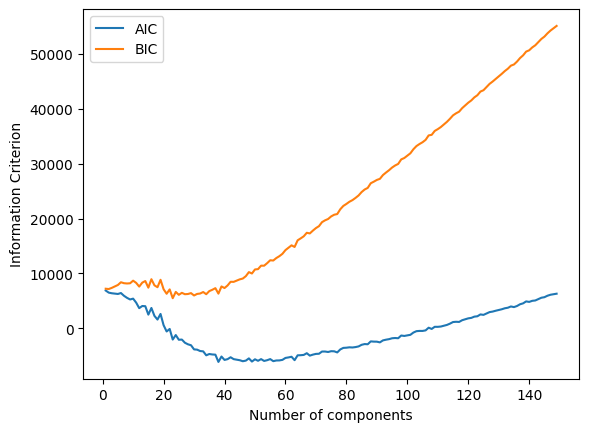

In [199]:
plt.plot(range(1, max_range), aic, label='AIC')
plt.plot(range(1, max_range), bic, label='BIC')
plt.legend()
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.show()

In [200]:
choose_aic=np.argmin(np.array(aic))+1
print(choose_aic)
choose_bic=np.argmin(np.array(aic))+1
print(choose_bic)

38
38


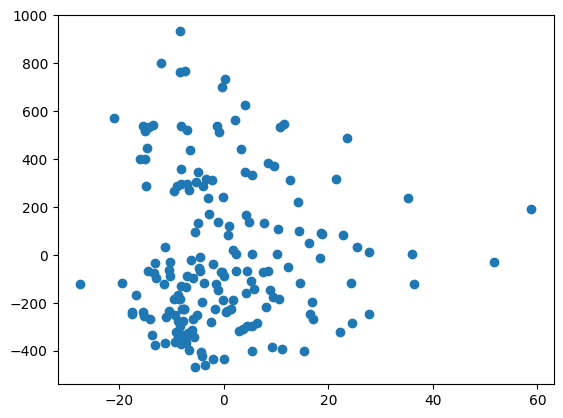

In [202]:
from sklearn.decomposition import PCA

decomposition = PCA(n_components=2)
result = decomposition.fit_transform(X)

plt.scatter(result[:,1],result[:,0])
plt.show()

In [205]:
gmm_aic = GMM()
gmm_aic.fit(X, choose_aic, printing=False)
gmm_bic = GMM()
gmm_bic.fit(X, choose_bic, printing=False)

aic_clustering = gmm_aic.get_membership(X)
bic_clustering = gmm_bic.get_membership(X)

aic_clustering, bic_clustering

-1617.8689248603573
1933.6291244914132
5466.023223860279
6277.883275898667
6326.0480807882395
-1514.6345060737572
2160.305866812303
5650.291177803127
6231.18239505613
6286.2675683089265
6334.323111801057


(array([31., 13., 22.,  3., 10.,  3., 20., 31., 20., 24., 26., 26., 22.,
        22., 22.,  0.,  3.,  3.,  3., 10., 20., 16., 31., 28., 24., 17.,
        10., 34., 10., 20.,  1., 26.,  3.,  3.,  3., 24., 10., 30., 26.,
        14., 14., 26., 10., 14., 14., 31., 20., 20.,  3.,  0., 22., 22.,
         3.,  3., 31., 23., 20.,  3.,  3.,  5.,  5.,  5.,  5., 11.,  8.,
        30., 16., 24.,  5.,  4., 34.,  6., 11.,  7., 28., 19., 19., 19.,
        25.,  7., 19., 16., 28., 17., 32., 16.,  8., 24., 18., 28., 30.,
        28., 17., 16., 16.,  4., 32., 19., 37.,  7., 19., 28., 21., 11.,
        24., 21., 28., 17., 37., 32.,  2., 11.,  8., 30., 21.,  8., 28.,
        11., 13., 18., 21., 37.,  7., 14.,  2., 37., 37., 17., 37., 18.,
        36., 36., 36., 36., 15., 15., 34., 27., 27.,  6.,  9.,  9.,  6.,
        27., 29., 34., 13., 27., 12., 29., 36., 29., 36., 12., 15., 27.,
        12.,  1.,  6.,  9., 12.,  6., 27., 34.,  9., 27.,  0., 35., 23.,
        33., 35., 35.,  9., 27.,  1.,  0., 35.,  6.

/home/bhavb/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


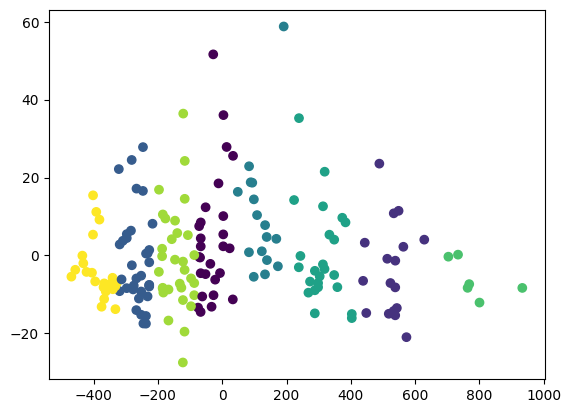

In [215]:
kmeans = KMeans().fit(X)
plt.scatter(result[:, 0], result[:, 1], c=kmeans.labels_.astype(float))
plt.show()

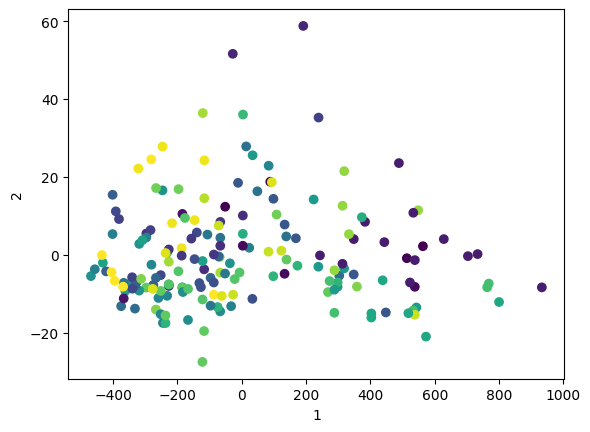

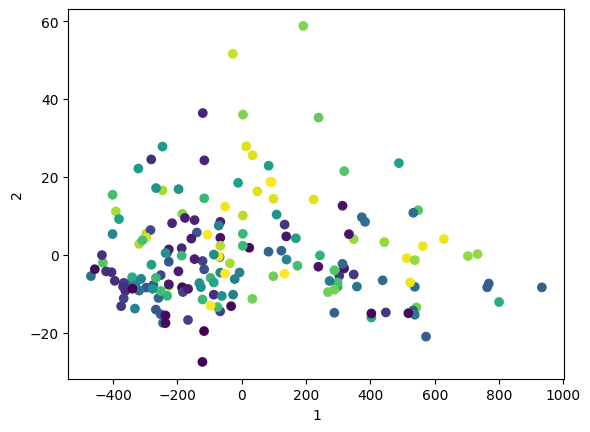

In [208]:
plt.scatter(result[:,0],result[:,1], c=aic_clustering)
plt.xlabel("1")
plt.ylabel("2")
plt.show()
plt.scatter(result[:,0],result[:,1], c=bic_clustering)
plt.xlabel("1")
plt.ylabel("2")
plt.show()

In [218]:
# Perform K-Means clustering and calculate the silhouette score
y_means = kmeans.predict(X)
silhouette_avg_kmeans = silhouette_score(X, y_means)
print("K-Means:", silhouette_avg_kmeans)

# Calculate the silhouette score for GMM with AIC
y_aic = gmm_aic.get_membership(X)
silhouette_avg_aic = silhouette_score(X, y_aic)
print("GMM with AIC:", silhouette_avg_aic)

# Calculate the silhouette score for GMM with BIC
y_bic = gmm_bic.get_membership(X)
silhouette_avg_bic = silhouette_score(X, y_bic)
print("GMM with BIC:", silhouette_avg_bic)

K-Means: 0.5369954815914436
GMM with AIC: -0.5056599713324692
GMM with BIC: -0.5549402877029493


> ##### Observations

K-Means tends to create spherical clusters and employs a hard-assignment approach where each data point is assigned exclusively to one cluster. It assumes that each data point strictly belongs to a single cluster at any given time. 

In contrast, Gaussian Mixture Model (GMM) uses a soft-assignment strategy, assigning probabilistic membership to each data point in relation to multiple clusters. Each data point can belong to a particular cluster with a certain non-zero probability, which is iteratively adjusted during the M-Step of the algorithm. 

This soft-assignment approach avoids the formation of strictly spherical clusters and leads to the creation of more flexible and appropriate cluster shapes. The key distinction between K-Means and GMM is that K-Means assigns each data point to a specific cluster based on geometric proximity, typically resulting in clusters that form spherical shapes. On the other hand, GMM assigns data points to clusters based on probabilistic considerations, allowing points to belong to clusters even if they are located outside the typical spherical cluster boundaries.